# Spoken Digit Classification
<br/>
<center>Francesco Di Salvo <br/> <i>Politecnico di Torino <br /> s282418@studenti.polito.it</i></center>
<br />

## Abstract
This document focuses on the Classification model used for predicting Spoken digits recorded in different circumstances. The dataset used contains 2000 spoken digits recorded by four people of numbers from 0 to 9 in English. We had to our proposal 1500 spoken digits for the developement phase, and the remaining 500 for the evalutation phase. Each audio track was recorded with a bit rate of 8KHz and proposed as a '.wav' file. I explored the recordings both in the time and frequency domain, in order to gain more insights and pre process the data in a proper way. For the classification model I used the Random Forest Classifier and I tried to give it pre processed data in both time and frequency domain, and I obtained the best performance by feeding it with Mel-frequency cepstral coefficients (MFFcs) that are derived from a type of cepstral representation of the audio clip. After a proper hyperparameters tuning, I find the best classifier for the predicting model that allow me to perform a 0.996 accuracy. 
    
## Data mining process
The data used for the developement and evaluation phase have a different format. In fact the developement dataset contained the files called with the format "id_label.wav" and of course in the evaluation set we had the format "id.wav". So, in order to manage this difference I developed one single method for the extraction of the information that requires the kind of data needed, with the keywords 'eval' and 'dev'. In order to extract the informations. I used the python's libraries "os" and "scipy". In particular the first one is used for taking the recording names of the current directory, and the second one, thanks to the "wav" module is used for read the audio files. The method wavfile.read() returns in output the sample rate and the samples of the audio track, that is actually the amplitude on each time stamp. After this process I had six objects, two arrays containing the sample rates of the audio signals (eval and dev), two samples of the collections (again eval and dev) and two other array, containing the labels for the developement set, and the indices for the evaluation set. 

In [1]:
import os 
import numpy as np
from scipy.io import wavfile

def get_data(type):
    
    if type not in ['eval','dev']:
        print("-- Parametro non riconosciuto")
        exit(0)
    
    path = '../Datasets/free-spoken-digit/' + type + '/'
    
    audio_files = os.listdir(path)
    
    # we have to initialize them
    # otherwise we cannot have access trough indices
    X = [None for i in range(len(audio_files))]
    y = [None for i in range(len(audio_files))]
    rates = [None for i in range(len(audio_files))]
    
    id_audio = None
    
    for audio_file in audio_files:
        
        """
            eval and dev have two different structures
                dev  : id_label.wav
                eval : id.wav 
        """ 
        
        # id
        if type == "dev":
            id_audio = int(audio_file.split("_")[0])
            y[id_audio] = int(audio_file.split(".")[0].split("_")[1])
        else:
            id_audio = int(audio_file.split(".")[0])
            y[id_audio] = id_audio
        
        complete_path = path + audio_file
        
        rates[id_audio], X[id_audio] = wavfile.read(complete_path)

    return rates, X, y 

In [2]:
Rates_eval, X_eval, ids  = get_data('eval')
Rates_dev,  X_dev, y_dev = get_data('dev')

## Data exploration
From wahat I obtained so far, I started looking for some insights. The first thing that I looked for, was the Sample Rate. In particular I checked if all the recordings was recorder with the same sample rate of 8KHz, so in order to check that, I just converted the lists of sample rates into set, because in this manner I avoided the duplicates. The result was as I expected, so both developement and evaluation datasets were recorded with the same sample rate of 8KHz.

After that, I plotted the amplitude in order to see graphically the audio tracks. I used in particular matplotlib and seaborn, that are two of the most common visualization libraries. The infographic gave me two significant informations: the recordings have different lengths and a huge variance among the amplitudes. In fact in the next process, I tried to  solve those issues as much as I could. 

In [3]:
print("Rates eval :\t", set(Rates_eval))
print("Rates dev  :\t", set(Rates_dev))

Rates eval :	 {8000}
Rates dev  :	 {8000}


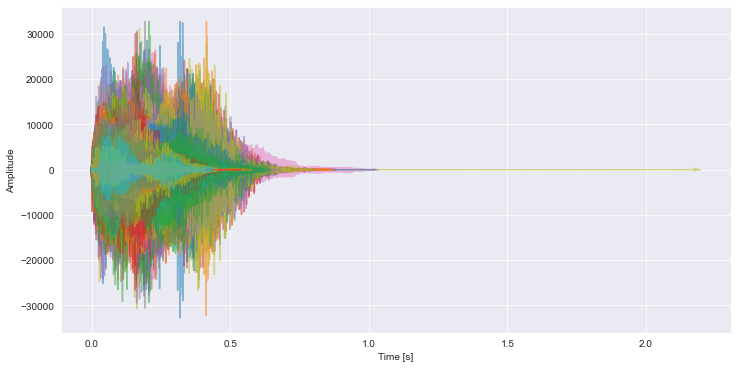

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_amplitude(X):
    sns.set_style("darkgrid")
    plt.figure(figsize=(12,6))

    for i,x in enumerate(X):

        length = x.shape[0] / Rates_dev[i]
        time = np.linspace(0., length, x.shape[0])
        plt.plot(time, x, alpha=0.5)
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        
    return plt

plot_amplitude(X_dev).show()

## Preprocessing
Thanks to the insights that I found during the exploratory analysis, I focused the attention of the lengths and the amplitudes. So, firstly, I normalized the data, in order to deal with more homogeneous signals. I used the z-score normalization, that substracts each value for the mean, and divide it with the standard deviation. The computation is already provided by Scipy, on its module "stats". After that, I created a list with all the audios' lenghts, and then I plotted them as an histograms. It showed that the most common lengths were around 3000 to 3500, and the less common ones were up to 5000 and above. So, I decided to trim all the tracks at 5000 and I stretched the shorter ones to 5000. This process will improve the model performance, because Random Forest (such as many other algorithms ) works better.

After those considerations in the time domain I decided to move to the frequency domain. Actually, as a first try, I feeded the Random Forest with the FFT (fast fourier transformed - a function that converts a signal from the time domain to the frequency domain) and I obtained such a good result. Then, while I was discussing with Andrea Cognolato (one of my collegues), he suggested me to have a look on the SFTF (Short-time Fourier transform) and on the MFC (mel-frequency Cepstrum). To be more precise, the STFT divides the signal into chunks and then it compute the fast fourier transformed on each chunk, separately; then the second one (MFC) is a representation of the short-term power spectrum of a sound. 

So, I tried to feed the RandomForestClassifier with the output of the SFTF and I actually improved my current performance, but when I used the MFCC I noticed a wider increment, in fact it allowed to achieve a score of 0.996. Furthermore, I decided to use the MFCC for transforming the signals to the frequency domain. 

In order to do that, I used librosa, a powerful library that allows to manipulate audio signals. The output of the librosa's MFCC method is actually a collection of indices, organized in a matrix. So it is a collection of matrix, and in order to give it to the classifier, I shaped it into a 2-D array, by transforming each matrix into a single array. Of course it is possible because we had a fixed length of signals, so those coefficient will have a fixed dimension too. 

In [5]:
from scipy.stats import zscore

def normalize(X):
    return [zscore(arr) for arr in X]

X_dev_norm = normalize(X_dev)
X_eval_norm = normalize(X_eval)

Text(0.5, 1.0, 'length_eval')

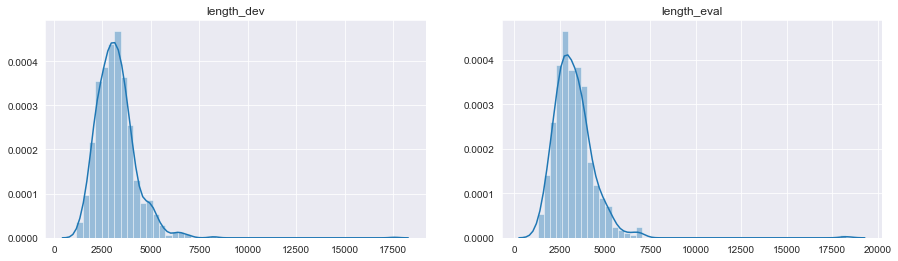

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

lengths_dev = [ len(audio) for audio in X_dev]
lengths_eval = [ len(audio) for audio in X_eval]

fig, ax = plt.subplots(1,2,figsize=(15,4))

sns.distplot(lengths_dev, ax=ax[0])
ax[0].set_title('length_dev')
sns.distplot(lengths_eval, ax=ax[1])
ax[1].set_title('length_eval')

In [9]:
def cut_and_stretch(X, threshold):
    temp =  [ arr if len(arr) <= threshold else arr[:threshold] for arr in X ]
    return  [np.pad(x, (0,thres-len(x)), constant_values=0.0) for x in temp]

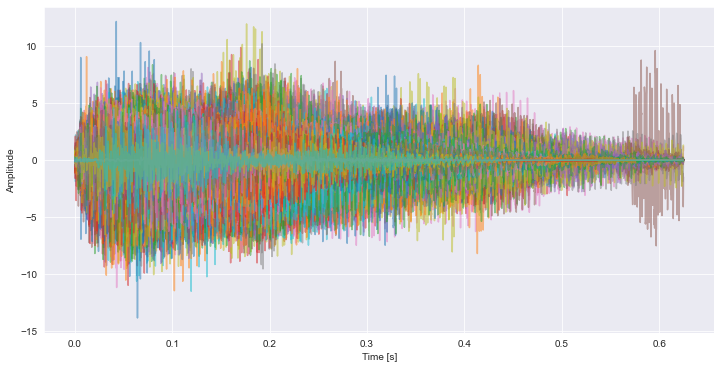

In [10]:
thres = 5000
X_dev_cut = cut_and_stretch(X_dev_norm,thres)
X_eval_cut = cut_and_stretch(X_eval_norm,thres)
plot_amplitude(X_dev_cut).show()

In [11]:
import librosa, librosa.display, librosa.core
import pandas as pd

MFCCs = [np.matrix(librosa.feature.mfcc(x)).flatten() for x in X_dev_cut ]
MFCCs_eval = [np.matrix(librosa.feature.mfcc(x)).flatten() for x in X_eval_cut ]

MFCCs = np.array(MFCCs).transpose(1,0,2).reshape(1500,200)
MFCCs_eval = np.array(MFCCs_eval).transpose(1,0,2).reshape(500,200)

## Classification model
Once I transformed the initial signals, I started modeling the classification model. I decided to use a Grid Search Cross Validation in order to take the best hyperparameters and I have chosen to try different values of "max_dept" (10,50,100,200) and "n_estimators" (500,1000,2000) and 4 folds for the evaluation process. The best parameters were max_depth equal to 200, and n_estimators equal to 2000. After that, I tested those hyperparameters with different randomized train set and test set, and I obtained results from 0.97 to 0.99. Therefore I finished to work on my model and I predicted the evaluation set with the previous Random Forest Classifier. 

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# hyperparams 
params_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [10,50,100,200]
}

X_train, X_test, y_train, y_test = train_test_split(MFCCs,y_dev, test_size=0.20, stratify=y_dev)

clf_init = RandomForestClassifier()

clf = GridSearchCV(clf_init, params_grid, cv=4, scoring='f1_macro', n_jobs=4, verbose=True)
clf.fit(X_train, y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:  4.5min finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [10, 50, 100, 200],
                         'n_estimators': [500, 1000, 2000]},
             scoring='f1_macro', verbose=True)

In [24]:
clf.best_params_

{'max_depth': 200, 'n_estimators': 2000}

In [32]:
X_train, X_test, y_train, y_test = train_test_split(MFCCs,y_dev, test_size=0.20, stratify=y_dev)
rf = RandomForestClassifier(max_depth = 200, n_estimators=2000)

In [33]:
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30
           2       0.94      1.00      0.97        30
           3       1.00      0.93      0.97        30
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00        30
           6       0.97      0.97      0.97        30
           7       1.00      0.97      0.98        30
           8       0.97      1.00      0.98        30
           9       1.00      1.00      1.00        30

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



## CSV Conversion and deploy
The submission must have a specific structure, so I needed to convert the predicted array into a pandas' dataframe, by using the ids vector obtained in the extraction phase - it was the name of the recording - and the predicted labels. I finally converted that into a csv file that I submitted to the proposal platform. 

In [34]:
def get_csv(ids, y):
    pd.DataFrame(dict(Id = ids,Predicted = y)).to_csv("submission.csv",sep=",",index=False)

In [58]:
get_csv(ids,y_pred)